## Complete Feature Importance Comparison for Mule Accounts

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as  sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [2]:
#import relevant csvs
acc_data = pd.read_csv("Account Data Cleaned.csv")
acc_holder = pd.read_csv("account_holder_imputed_data.csv")
mule_flag = pd.read_csv("Mule Flag.csv")

In [3]:
#drop missing values for mule flag
mule_flag = mule_flag.dropna()
mule_flag = mule_flag.set_index("Identifier")
mule_flag


,MuleAccount
Identifier,
ID_0001,0.0
ID_0002,0.0
ID_0005,0.0
ID_0006,0.0
ID_0007,0.0
...,...
ID_0996,0.0
ID_0997,0.0
ID_0998,0.0


Merge all dataframes together

In [4]:
acc_data = acc_data.set_index("Identifier")
acc_holder = acc_holder.set_index("Identifier")

In [5]:
combined_df = acc_holder.join(mule_flag, how = 'right')
final_df = acc_data.join(combined_df, how = 'right')

Ensure the dataframe is left with required categorical data

In [6]:
final_df = final_df.drop(["Income", "CreditScore", "LoanAmount", "SocialMediaUsageHours", "ShoppingFrequencyPerMonth", "Age"], axis = 1)

In [7]:
final_df.head()

,AccountLength,AverageBalance,NumTransactions,NumDeposits,NumWithdrawals,NumTransfers,NumLoans,NumCreditCards,NumSavingsAccounts,Gender,...,OccupancyStatus,NumDependents,HealthInsuranceStatus,CreditScore_Rating,Age group,Income_bin,LoanAmount_bin,SocialMediaUsageHours_bin,ShoppingFrequencyPerMonth_bin,MuleAccount
Identifier,,,,,,,,,,,,,,,,,,,,,
ID_0001,15-19,20000-29999,300-399,200-249,250-299,0-49,6-7,2,0,Female,...,Owner,3.0,Yes,Bad,Pre-Retirement,"[90000, 100000)","[40000, 50000)","[20, 25)","[5, 10)",0.0
ID_0002,0-4,20000-29999,300-399,200-249,100-149,0-49,4-5,4,2,Male,...,Owner,2.0,No,Bad,Young Adults,"[70000, 80000)","[0, 10000)","[5, 10)","[10, 15)",0.0
ID_0005,5-9,10000-19999,200-299,0-49,0-49,50-99,8-9,3,2,Male,...,Owner,1.0,No,Very Good,Established Adults,"[80000, 90000)","[20000, 30000)","[10, 15)","[5, 10)",0.0
ID_0006,25-29,20000-29999,300-399,50-99,250-299,0-49,6-7,1,2,Male,...,Renter,4.0,No,Bad,Established Adults,"[90000, 100000)","[0, 10000)","[15, 20)","[0, 5)",0.0
ID_0007,20-24,10000-19999,100-199,200-249,150-199,50-99,6-7,1,1,Female,...,Renter,2.0,Yes,Bad,Pre-Retirement,"[70000, 80000)","[0, 10000)","[10, 15)","[5, 10)",0.0


In [8]:
final_df['NumDependents'] = np.ceil(final_df['NumDependents']).astype(int).astype(str)
final_df['NumCreditCards'] = np.ceil(final_df['NumCreditCards']).astype(int).astype(str)
final_df['NumSavingsAccounts'] = np.ceil(final_df['NumSavingsAccounts']).astype(int).astype(str)

In [9]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 948 entries, ID_0001 to ID_1000
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AccountLength                  948 non-null    object 
 1   AverageBalance                 948 non-null    object 
 2   NumTransactions                948 non-null    object 
 3   NumDeposits                    948 non-null    object 
 4   NumWithdrawals                 948 non-null    object 
 5   NumTransfers                   948 non-null    object 
 6   NumLoans                       948 non-null    object 
 7   NumCreditCards                 948 non-null    object 
 8   NumSavingsAccounts             948 non-null    object 
 9   Gender                         948 non-null    object 
 10  EmploymentStatus               948 non-null    object 
 11  MaritalStatus                  948 non-null    object 
 12  OccupancyStatus                948 non-null  

### Complete Feature Importances Check
Two different methods will be used
1. Logistic Regression
2. Random Forest Classifier

In [10]:
# Split Data into X and Y
X = final_df.drop(columns = ["MuleAccount"])
y = final_df["MuleAccount"].astype('int')

#saving column names into a list
cols = X.columns.tolist()

There are two choices of encoder, they will be paired with the two named method to check which encoder + method is the best way in determining feature importances.

In [11]:
#One Hot Encoding Method
onehot_encoder = ColumnTransformer([('cat', OneHotEncoder(drop='first'), cols)])

#Ordinal Encoding Method
ord_encoder = ColumnTransformer([('cat', OrdinalEncoder(), cols)])

#One Hot for XGB
xgbonehot_encoder = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cols)])

Preparing Different Pipelines for Multivariate Model Comparison

In [12]:
#Pipeline A: onehot and linear regression
pipeA = Pipeline([
    ('preprocess', onehot_encoder),
    ('scaling', StandardScaler(with_mean=False)),
    ('lreg', LogisticRegression(max_iter=1000))
])

#Pipeline B: onehot and random forest
pipeB = Pipeline([
    ('preprocess', onehot_encoder),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

#Pipeline C: ordinal and linear regression
pipeC = Pipeline([
    ('preprocess', ord_encoder),
    ('scaling', StandardScaler(with_mean=False)),
    ('lreg', LogisticRegression(max_iter=1000))
])

#Pipeline D: ordinal and random forest
pipeD = Pipeline([
    ('preprocess', ord_encoder),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

#Pipeline E: onehot and XGB
pipeE = Pipeline([
    ('preprocess', xgbonehot_encoder),
    ('xgb', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state=42))
])

In [13]:
my_models = {
    'A (OneHot + Logistic Reg.)': pipeA,
    'B (OneHot + Random Forest)': pipeB,
    'C (Ordinal + Logistic Reg.)': pipeC,
    'D (Ordinal + Random Forest)': pipeD,
    'E (OneHot + XGBoost)': pipeE
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, pipelines in my_models.items():
    scores = cross_val_score(pipelines, X, y, cv = cv, scoring = 'roc_auc')
    print(f"{model}: ROC AUC = {scores.mean():.3f} ± {scores.std():.3f}")

A (OneHot + Logistic Reg.): ROC AUC = 0.557 ± 0.062
B (OneHot + Random Forest): ROC AUC = 0.543 ± 0.036
C (Ordinal + Logistic Reg.): ROC AUC = 0.452 ± 0.095
D (Ordinal + Random Forest): ROC AUC = 0.529 ± 0.084


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:42:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:42:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:42:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:42:55] WARNING: C:\actions-r

E (OneHot + XGBoost): ROC AUC = 0.533 ± 0.068


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:42:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline A and B seems to have higher score.
We will conduct feature importance check with these two pipelines.

In [14]:
#Pipeline A
pipeA.fit(X, y)

#extract column name
ohe = pipeA.named_steps['preprocess']
feature_names = ohe.get_feature_names_out(input_features = X.columns)

#extract logistic regression coefficients
coefficients = pipeA.named_steps['lreg'].coef_[0]

importancesA = pd.DataFrame({'Feature_Category': feature_names,
                             'Coefficient': coefficients}).sort_values(by = 'Coefficient', ascending=False).reset_index(drop = True)

In [ ]:
importancesA

,Feature_Category,Coefficient
0,cat__AccountLength_25-29,0.526833
1,cat__NumCreditCards_2,0.334011
2,cat__NumLoans_4-5,0.332212
3,cat__OccupancyStatus_Renter,0.211450
4,cat__NumTransactions_200-299,0.196544
...,...,...
71,cat__Age group_Retirees,-0.371997
72,cat__NumWithdrawals_100-149,-0.401149
73,cat__NumTransfers_150-199,-0.414788
74,cat__CreditScore_Rating_Excellent,-0.475477


In [16]:
#Pipeline B
pipeB.fit(X, y)

#extract column name
ohe = pipeB.named_steps['preprocess']
feature_names = ohe.get_feature_names_out(input_features = X.columns)

#extract logistic regression coefficients
importances = pipeB.named_steps['rf'].feature_importances_

importancesB = pd.DataFrame({'Feature_Category': feature_names,
                             'Coefficient': importances}).sort_values(by = 'Coefficient', ascending=False).reset_index(drop = True)

In [17]:
importancesB

,Feature_Category,Coefficient
0,cat__AccountLength_25-29,0.036483
1,cat__NumDependents_2,0.025278
2,cat__OccupancyStatus_Renter,0.022977
3,cat__EmploymentStatus_Retired,0.018021
4,cat__NumWithdrawals_100-149,0.017881
...,...,...
71,cat__Age group_Retirees,0.008897
72,"cat__Income_bin_[70000, 80000)",0.007983
73,cat__NumDeposits_200-249,0.007846
74,cat__Age group_Young Adults,0.007699


Conclusion: Use Logistic regression which clearly indicates which feature leads to money muling.

### Plot for Top 5 Coefficients in Logistic Regression

C:\Users\User\AppData\Local\Temp\ipykernel_49252\1341443213.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Split_Label', y = 'Coefficient', data = top5categories, palette='pastel')


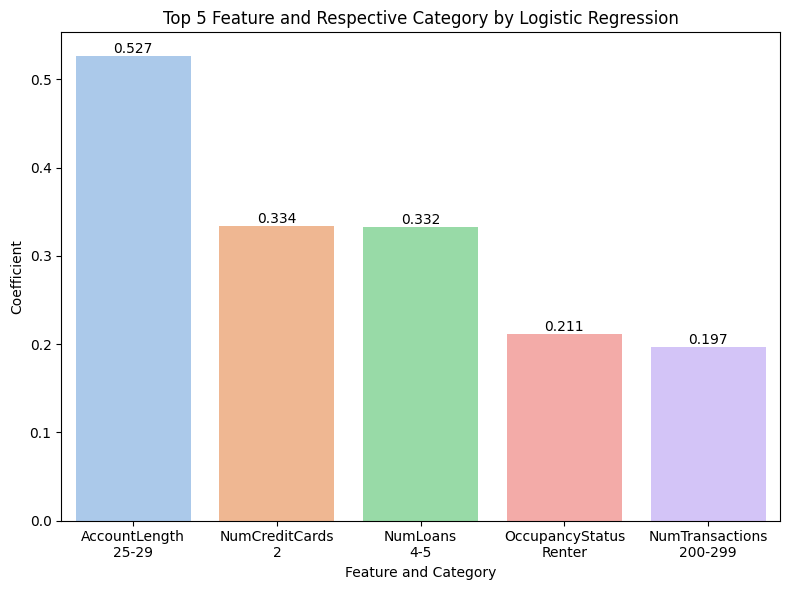

In [33]:
top5categories = importancesA.reindex(importancesA['Coefficient'].sort_values(ascending=False).index).head(5)
top5categories['Feature_Category'] = top5categories['Feature_Category'].str.replace('cat__', '', regex=False)

# Split labels at the first underscore and join with newline
def split_label(label):
    parts = label.split('_', 1)  # split only on first underscore
    if len(parts) == 2:
        return parts[0] + '\n' + parts[1]
    else:
        return label

top5categories['Split_Label'] = top5categories['Feature_Category'].apply(split_label)

plt.figure(figsize=(8,6))
sns.barplot(x = 'Split_Label', y = 'Coefficient', data = top5categories, palette='pastel')

plt.title('Top 5 Feature and Respective Category by Logistic Regression')
plt.xlabel('Feature and Category')
plt.ylabel('Coefficient')

for i, coef in enumerate(top5categories['Coefficient']):
    plt.text(i, coef, f'{coef:.3f}', ha = 'center', va = 'bottom', fontsize = 10)

plt.tight_layout()
plt.show()
